In [12]:
import matplotlib
import poloniex
import datetime

# import holoviews as hv
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/IPython/core/magics/pylab.py:160: UserWarning:

pylab import has clobbered these variables: ['trace']
`%matplotlib` prevents importing * from pylab and numpy



In [17]:
import plotly
plotly.offline.init_notebook_mode()
from plotly.offline import iplot 
import plotly.graph_objs as go
import backtrader
import pandas as pd
# hv.notebook_extension('matplotlib')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Let's Start by checking your balances. You need to have your keys stored somewhere the bitfinex client can find.

Let's Download some historic series:

In [ ]:
# wget.download('http://api.bitcoincharts.com/v1/csv/bitfinexUSD.csv.gz','bitfinexUSD.csv.gz')

In [5]:
bitcoin = pd.read_csv('http://api.bitcoincharts.com/v1/csv/bitfinexUSD.csv.gz', compression='gzip')

In [8]:
bitcoin.columns = ['datetime', 'price', 'volume']
bitcoin['datetime'] = pd.to_datetime(bitcoin.datetime, unit='s')
bitcoin.set_index(['datetime'], inplace=True)
bitcoin.head()

datetime  price     volume
0 1970-01-01 00:00:01.364767669   93.3  80.628518
1 1970-01-01 00:00:01.364767693  100.0  20.000000
2 1970-01-01 00:00:01.364767694  100.0   1.000000
3 1970-01-01 00:00:01.364767696  100.0   5.900000
4 1970-01-01 00:00:01.364767699  100.0  29.833879

In [4]:
end = datetime.datetime.now()
start = end - datetime.timedelta(days=364)
ether = poloniex.get_ohlc('USDT_ETH',start, end)

In [5]:
print(ether.info())
ether.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 104831 entries, 2016-07-15 19:55:00 to 2017-07-14 19:45:00
Data columns (total 7 columns):
close              104831 non-null float64
high               104831 non-null float64
low                104831 non-null float64
open               104831 non-null float64
quoteVolume        104831 non-null float64
volume             104831 non-null float64
weightedAverage    104831 non-null float64
dtypes: float64(7)
memory usage: 6.4 MB
None


close           high            low           open  \
count  104831.000000  104831.000000  104831.000000  104831.000000   
mean       57.806143      57.990900      57.611747      57.806083   
std        90.184823      90.509489      89.837158      90.186269   
min         5.883966       5.964728       5.854031       5.900000   
25%        10.773000      10.789351      10.760000      10.771000   
50%        12.494620      12.506414      12.473878      12.494620   
75%        50.600001      50.748487      50.505490      50.602178   
max       405.000000     408.128700     395.800000     405.000000   

         quoteVolume        volume  weightedAverage  
count  104831.000000  1.048310e+05    104831.000000  
mean      145.054806  1.485926e+04        57.800037  
std       410.346051  5.276550e+04        90.170340  
min         0.000000  0.000000e+00         5.900298  
25%         0.208724  2.278063e+00        10.771000  
50%        11.110518  1.807105e+02        12.493145  
75%       112.000859  5.807405e+03        50.612988  
max     13335.125868  2.094404e+06       399.911100

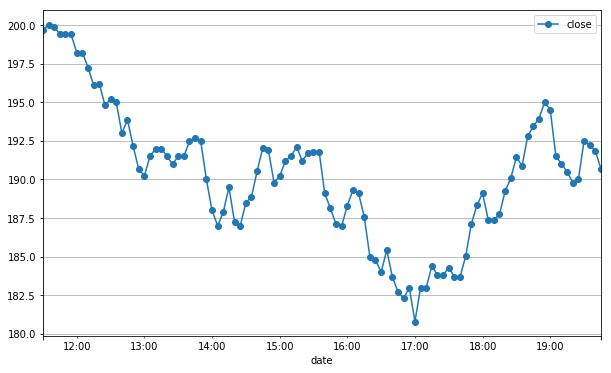

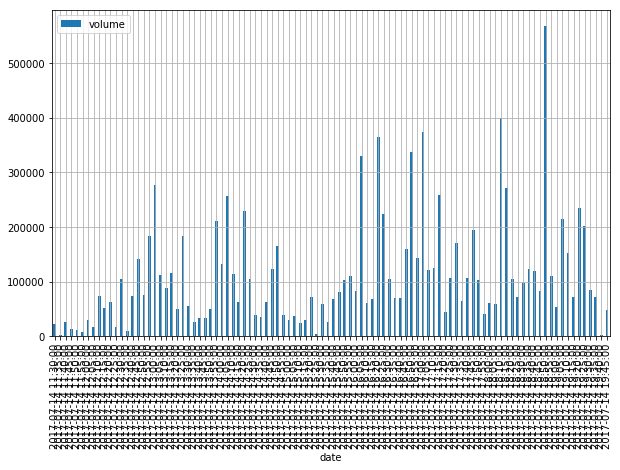

In [8]:
ether[-100:].plot(y='close',figsize=(10,6), style='-o', grid=True);
ether[-100:].plot(y='volume', kind='bar',figsize=(10,6), grid=True);

In [18]:
trace = go.Candlestick(x=ether.index,
                       open=ether.open,
                       high=ether.high,
                       low=ether.low,
                       close=ether.close)
data = [trace]
iplot(data, filename='simple_candlestick')


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Creating a strategy

In [19]:
import backtrader.indicators as btind
import backtrader.analyzers as btanalyzers

In [20]:
def run_test():
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    res = cerebro.run()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    return res

In [21]:
class SMA_CrossOver(backtrader.Strategy):

    params = (('fast', 12), ('slow', 26))

    def __init__(self):
        self.rsi = btind.RSI()
        sma_fast = btind.SMA(period=self.p.fast)
        sma_slow = btind.SMA(period=self.p.slow)

        self.buysig = btind.CrossOver(sma_fast, sma_slow)

    def next(self):
        if self.position.size:
#             if (self.buysig < 0):
#                 self.sell()

#       elif (self.buysig > 0):
#                 self.buy()
            if (self.rsi<=50):
                self.sell()

        elif (self.rsi>=60):
            self.buy()
            
class Aroon(backtrader.Strategy):
    params = (('period',70),)
    def __init__(self):
        self.a_up = btind.AroonUp(period=self.p.period)
        self.a_down = btind.AroonDown(period=self.p.period)
    def next(self):
        if self.position.size:
            if self.a_down >= 95:
                self.sell()
        elif self.a_up >=97:
            self.buy()

In [22]:
class MarcosStrat(backtrader.Strategy):
    def __init__(self):
        self.delta = 2
        self.price_in = None
        self.price_out = 100000
        self.trailing = 0.5
        self.target = 10000000
    def next(self):
        self.price_out = self.data.close[0] if self.price_out is None else self.price_out
        if self.position.size:
            #self.price_in = self.data.close[0] if self.price_in is None else self.price_in
            print("Sell. Price: {}, price_out: {}, price_in:{}".format(self.data.close[0],self.price_out, self.price_in))
            if self.data.close[0] - self.price_in >= self.delta:
                #self.target =  self.data.close-self.trailing if self.data.close > self.target else self.target 
                #if self.data.close <= self.target:
                self.sell()
                self.price_out = self.data.close[0]
        elif self.data.close[0] - self.price_out <= -self.delta:
            
            print("{}.Price: {}, price_out: {}, price_in:{}".format(self.position.size,self.data.close[0],self.price_out, self.price_in))
            
            #self.target =  self.data.close+self.trailing if self.data.close < self.target else self.target 
            #if self.data.close >= self.target:
            self.buy()
            self.price_in = self.data.close[0]

In [28]:
cerebro = backtrader.Cerebro()
cerebro.broker.setcash(100000.0)
data2 = backtrader.feeds.PandasData(dataname=ether, datetime=None)
cerebro.adddata(data2)
cerebro.broker.setcommission(commission=0.001)
# cerebro.addstrategy(SMA_CrossOver)
cerebro.addstrategy(MarcosStrat)
#cerebro.addanalyzer(btanalyzers.SharpeRatio, _name='mysharpe')
res = run_test()
#print('Sharpe Ratio:', res[0].analyzers.mysharpe.get_analysis())

Starting Portfolio Value: 100000.00
0.Price: 12.19533993, price_out: 100000, price_in:None
Sell. Price: 12.19534789, price_out: 100000, price_in:12.19533993
Sell. Price: 12.1953481, price_out: 100000, price_in:12.19533993
Sell. Price: 12.1953481, price_out: 100000, price_in:12.19533993
Sell. Price: 12.31999909, price_out: 100000, price_in:12.19533993
Sell. Price: 12.31999993, price_out: 100000, price_in:12.19533993
Sell. Price: 12.21000103, price_out: 100000, price_in:12.19533993
Sell. Price: 12.21000103, price_out: 100000, price_in:12.19533993
Sell. Price: 12.39999999, price_out: 100000, price_in:12.19533993
Sell. Price: 12.36504067, price_out: 100000, price_in:12.19533993
Sell. Price: 12.36504064, price_out: 100000, price_in:12.19533993
Sell. Price: 12.30778388, price_out: 100000, price_in:12.19533993
Sell. Price: 12.32389869, price_out: 100000, price_in:12.19533993
Sell. Price: 12.32389869, price_out: 100000, price_in:12.19533993
Sell. Price: 12.18592463, price_out: 100000, price_in

Sell. Price: 11.48599999, price_out: 100000, price_in:12.19533993
Sell. Price: 11.48599999, price_out: 100000, price_in:12.19533993
Sell. Price: 11.5, price_out: 100000, price_in:12.19533993
Sell. Price: 11.5, price_out: 100000, price_in:12.19533993
Sell. Price: 11.5, price_out: 100000, price_in:12.19533993
Sell. Price: 11.49999968, price_out: 100000, price_in:12.19533993
Sell. Price: 11.38613861, price_out: 100000, price_in:12.19533993
Sell. Price: 11.38613861, price_out: 100000, price_in:12.19533993
Sell. Price: 11.38613861, price_out: 100000, price_in:12.19533993
Sell. Price: 11.38613861, price_out: 100000, price_in:12.19533993
Sell. Price: 11.49993032, price_out: 100000, price_in:12.19533993
Sell. Price: 11.49993032, price_out: 100000, price_in:12.19533993
Sell. Price: 11.49992297, price_out: 100000, price_in:12.19533993
Sell. Price: 11.49992297, price_out: 100000, price_in:12.19533993
Sell. Price: 11.49992297, price_out: 100000, price_in:12.19533993
Sell. Price: 11.49992297, price

Sell. Price: 13.7, price_out: 100000, price_in:12.19533993
Sell. Price: 13.71318082, price_out: 100000, price_in:12.19533993
Sell. Price: 13.77999838, price_out: 100000, price_in:12.19533993
Sell. Price: 13.65341391, price_out: 100000, price_in:12.19533993
Sell. Price: 13.80286917, price_out: 100000, price_in:12.19533993
Sell. Price: 13.67668295, price_out: 100000, price_in:12.19533993
Sell. Price: 13.6966901, price_out: 100000, price_in:12.19533993
Sell. Price: 13.6068295, price_out: 100000, price_in:12.19533993
Sell. Price: 13.6305772, price_out: 100000, price_in:12.19533993
Sell. Price: 13.6305772, price_out: 100000, price_in:12.19533993
Sell. Price: 13.6305772, price_out: 100000, price_in:12.19533993
Sell. Price: 13.64, price_out: 100000, price_in:12.19533993
Sell. Price: 13.57, price_out: 100000, price_in:12.19533993
Sell. Price: 13.5, price_out: 100000, price_in:12.19533993
Sell. Price: 13.650579, price_out: 100000, price_in:12.19533993
Sell. Price: 13.75, price_out: 100000, pric

Sell. Price: 12.544561999999999, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.544561999999999, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.682, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.68, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.682, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.682, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.682, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.682, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.7, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.69999999, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.69999999, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.62, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.606961590000001, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.69879138, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.69879138, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.69879138, price_out: 14.2001001, price_in:12.2
Sell. Price: 12

Sell. Price: 10.59215393, price_out: 14.2001001, price_in:12.2
Sell. Price: 10.47129999, price_out: 14.2001001, price_in:12.2
Sell. Price: 10.38000001, price_out: 14.2001001, price_in:12.2
Sell. Price: 10.42, price_out: 14.2001001, price_in:12.2
Sell. Price: 10.35, price_out: 14.2001001, price_in:12.2
Sell. Price: 10.26800001, price_out: 14.2001001, price_in:12.2
Sell. Price: 10.30527359, price_out: 14.2001001, price_in:12.2
Sell. Price: 10.25165004, price_out: 14.2001001, price_in:12.2
Sell. Price: 10.36259628, price_out: 14.2001001, price_in:12.2
Sell. Price: 10.35314892, price_out: 14.2001001, price_in:12.2
Sell. Price: 10.28920004, price_out: 14.2001001, price_in:12.2
Sell. Price: 10.35, price_out: 14.2001001, price_in:12.2
Sell. Price: 10.1500001, price_out: 14.2001001, price_in:12.2
Sell. Price: 9.78390105, price_out: 14.2001001, price_in:12.2
Sell. Price: 10.12580985, price_out: 14.2001001, price_in:12.2
Sell. Price: 10.01972853, price_out: 14.2001001, price_in:12.2
Sell. Price:

Sell. Price: 10.28890087, price_out: 14.2001001, price_in:12.2
Sell. Price: 10.28890087, price_out: 14.2001001, price_in:12.2
Sell. Price: 10.28890087, price_out: 14.2001001, price_in:12.2
Sell. Price: 10.47887367, price_out: 14.2001001, price_in:12.2
Sell. Price: 10.30731468, price_out: 14.2001001, price_in:12.2
Sell. Price: 10.36457768, price_out: 14.2001001, price_in:12.2
Sell. Price: 10.36457768, price_out: 14.2001001, price_in:12.2
Sell. Price: 10.35957768, price_out: 14.2001001, price_in:12.2
Sell. Price: 10.35957768, price_out: 14.2001001, price_in:12.2
Sell. Price: 10.35957768, price_out: 14.2001001, price_in:12.2
Sell. Price: 10.35957768, price_out: 14.2001001, price_in:12.2
Sell. Price: 10.35457769, price_out: 14.2001001, price_in:12.2
Sell. Price: 10.35457769, price_out: 14.2001001, price_in:12.2
Sell. Price: 10.30731383, price_out: 14.2001001, price_in:12.2
Sell. Price: 10.30731383, price_out: 14.2001001, price_in:12.2
Sell. Price: 10.29731383, price_out: 14.2001001, price_

Sell. Price: 12.41999982, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.34001121, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.34, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.32765999, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.34, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.34, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.41999992, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.41999994, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.27, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.41999634, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.42, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.49999891, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.49999533, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.30000011, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.43754999, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.30887042, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.316873

Sell. Price: 11.127, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.02170783, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.1157731, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.06000134, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.06000134, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.06000134, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.06000134, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.06000134, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.06000134, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.127, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.127, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.127, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.127, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.127, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.127, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.127, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.127, price_out: 1

Sell. Price: 11.07018049, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.07018049, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.07018049, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.07018049, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.07018049, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.07018049, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.19399538, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.19399538, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.19399538, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.19399538, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.19399538, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.19399538, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.19399538, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.17699998, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.17699998, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.17699998, price_out: 14.2001001, price_

Sell. Price: 10.76998856, price_out: 14.2001001, price_in:12.2
Sell. Price: 10.76998856, price_out: 14.2001001, price_in:12.2
Sell. Price: 10.76998856, price_out: 14.2001001, price_in:12.2
Sell. Price: 10.76998856, price_out: 14.2001001, price_in:12.2
Sell. Price: 10.76998856, price_out: 14.2001001, price_in:12.2
Sell. Price: 10.76998856, price_out: 14.2001001, price_in:12.2
Sell. Price: 10.76998856, price_out: 14.2001001, price_in:12.2
Sell. Price: 10.76998856, price_out: 14.2001001, price_in:12.2
Sell. Price: 10.76998856, price_out: 14.2001001, price_in:12.2
Sell. Price: 10.76998856, price_out: 14.2001001, price_in:12.2
Sell. Price: 10.76998856, price_out: 14.2001001, price_in:12.2
Sell. Price: 10.76999999, price_out: 14.2001001, price_in:12.2
Sell. Price: 10.77, price_out: 14.2001001, price_in:12.2
Sell. Price: 10.77, price_out: 14.2001001, price_in:12.2
Sell. Price: 10.77, price_out: 14.2001001, price_in:12.2
Sell. Price: 10.77, price_out: 14.2001001, price_in:12.2
Sell. Price: 10.

Sell. Price: 11.27191579, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.27191579, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.4, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.4, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.4, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.4, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.4, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.33943478, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.4, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.4, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.4, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.4, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.4, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.38, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.4, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.4, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.4, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.41705516, 

Sell. Price: 11.02498865, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.02498865, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.02498865, price_out: 14.2001001, price_in:12.2
Sell. Price: 10.96390517, price_out: 14.2001001, price_in:12.2
Sell. Price: 10.90000104, price_out: 14.2001001, price_in:12.2
Sell. Price: 10.90000225, price_out: 14.2001001, price_in:12.2
Sell. Price: 10.99574979, price_out: 14.2001001, price_in:12.2
Sell. Price: 10.98756616, price_out: 14.2001001, price_in:12.2
Sell. Price: 10.89846677, price_out: 14.2001001, price_in:12.2
Sell. Price: 10.96199999, price_out: 14.2001001, price_in:12.2
Sell. Price: 10.97361686, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.00199633, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.00199633, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.00199633, price_out: 14.2001001, price_in:12.2
Sell. Price: 10.84800535, price_out: 14.2001001, price_in:12.2
Sell. Price: 10.84800527, price_out: 14.2001001, price_

Sell. Price: 12.21499985, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.21499985, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.21499985, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.19999986, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.16, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.15001124, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.11101351, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.10200984, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.1, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.1, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.08975427, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.08975427, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.08975427, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.08975427, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.10500001, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.17399945, price_out: 14.2001001, price_in:12.2
Sell. Price:

Sell. Price: 11.6571907, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.6571907, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.69503209, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.69503209, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.60111, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.60111, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.60111, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.59013537, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.66166403, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.58520827, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.58520827, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.6315491, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.570000480000001, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.570000480000001, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.59731301, price_out: 14.2001001, price_in:12.2
Sell. Price: 11.59731301, price_out: 14.2001001, pric

Sell. Price: 12.11246324, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.11246324, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.15116609, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.15116609, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.15116609, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.15116609, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.08, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.08, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.08, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.08, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.08, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.03550737, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.03550737, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.03550737, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.03550737, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.00902863, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.009028

Sell. Price: 12.79499999, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.79499999, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.79499999, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.79499999, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.72000001, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.72000001, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.79499996, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.7, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.7, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.7, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.7, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.7, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.79152002, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.79152002, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.79152002, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.79152002, price_out: 14.2001001, price_in:12.2
Sell. Price: 12.70000002000

Sell. Price: 11.85299999, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.8300384, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.84199999, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.83, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.84199962, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.84199962, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.84199764, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.76355257, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.76355257, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.69149737, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.69150583, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.82856572, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.82856572, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.82856572, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.7, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.7, price_out: 14.21, pr

Sell. Price: 12.00714998, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.00714998, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.97100019, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.97100019, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.97100019, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.97100019, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.97100019, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.97100019, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.97100019, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.97100019, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.97100019, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.04430893, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.04430893, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.04430875, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.04430875, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.04430875,

Sell. Price: 12.14308234, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.14308234, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.14308234, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.14308234, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.14308234, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.14308234, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.14308234, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.14308234, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.14308234, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.15999998, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.15999998, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.15999998, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.15999998, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.15999998, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.15999998, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.15999998,

Sell. Price: 11.5671683, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.5671683, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.5671683, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.5671683, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.52419271, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.52419271, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.52419271, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.52419271, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.5278932, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.52417957, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.52417957, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.54882651, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.54882651, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.54882651, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.54882651, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.52416297, pric

Sell. Price: 10.45, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.45, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.43000001, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.43000001, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.43000001, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.40310602, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.40310602, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.44989086, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.39260157, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.44989084, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.44989084, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.44989084, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.44989084, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.47, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.47, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.47, price_out: 14.21, price_in:12

Sell. Price: 11.10000077, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.16, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.16, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.162, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.10000001, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.10000013, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.10000001, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.10000001, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.10000001, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.10000001, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.10000002, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.19789412, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.10000001, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.10000001, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.10000001, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.10000002, price_out: 14.21

Sell. Price: 10.9682056, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.950852470000001, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.88675118, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.91800109, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.87000004, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.87000004, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.93530152, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.96809639, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.87044348, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.87044348, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.90767426, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.88694858, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.933434160000001, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.95999981, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.95999963, price_out: 14.21, price_in:12.20010203
Sell. Price:

Sell. Price: 10.5, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.461, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.461, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.46100001, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.5, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.469, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.46920002, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.53246275, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.45652857, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.53245166, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.44008269, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.44008269, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.44008269, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.40815484, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.40815484, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.38000165, price_out: 14.21, price_in:1

Sell. Price: 9.87000012, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.93712411, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.93578381, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.93577814, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.904, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.90399723, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.82574989, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.75635676, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.81399869, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.75, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.68318479, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.75999999, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.75999862, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.68864107, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.74864353, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.74864353, price_out: 14.21, price_in

Sell. Price: 9.93630305, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.01999756, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.93630346, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.93630346, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.01999394, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.9852469, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.99999994, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.974706, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.93630455, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.93630464, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.93630464, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.01999093, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.95322345, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.95322345, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.96486047, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.97406134, price_out: 14.2

Sell. Price: 9.88504998, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.902, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.81802464, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.82101068, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.821, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.82102135, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.82103277, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.82100202, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.82100202, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.82100202, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.89898414, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.89898414, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.89106901, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.82108602, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.82109776, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.89839421, price_out: 14.21, price_i

Sell. Price: 9.20666404, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.20666407, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.20666407, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.21820001, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.29679868, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.22085965, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.22085965, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.29500952, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.23364873, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.23364873, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.23364857, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.22, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.22, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.2481629, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.22000009, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.22000009, price_out: 14.21, price_in:1

Sell. Price: 8.41751665, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.41751665, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.4039984, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.3, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.3, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.3, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.27169814, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.34199999, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.342, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.35646242, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.38385471, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.41252772, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.49899999, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.42700033, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.49616805, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.49616805, price_out: 14.21, price_in:12.20010203
Sel

Sell. Price: 6.87000006, price_out: 14.21, price_in:12.20010203
Sell. Price: 6.95, price_out: 14.21, price_in:12.20010203
Sell. Price: 6.8700000800000005, price_out: 14.21, price_in:12.20010203
Sell. Price: 6.87, price_out: 14.21, price_in:12.20010203
Sell. Price: 6.85842825, price_out: 14.21, price_in:12.20010203
Sell. Price: 6.87, price_out: 14.21, price_in:12.20010203
Sell. Price: 6.9, price_out: 14.21, price_in:12.20010203
Sell. Price: 7.09268109, price_out: 14.21, price_in:12.20010203
Sell. Price: 7.02, price_out: 14.21, price_in:12.20010203
Sell. Price: 7.0327084, price_out: 14.21, price_in:12.20010203
Sell. Price: 7.11999999, price_out: 14.21, price_in:12.20010203
Sell. Price: 7.18782653, price_out: 14.21, price_in:12.20010203
Sell. Price: 7.21690458, price_out: 14.21, price_in:12.20010203
Sell. Price: 7.25, price_out: 14.21, price_in:12.20010203
Sell. Price: 7.25147052, price_out: 14.21, price_in:12.20010203
Sell. Price: 7.43550001, price_out: 14.21, price_in:12.20010203
Sell. 

Sell. Price: 8.39543715, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.3678654, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.28699006, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.27879024, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.27879025, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.25522548, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.27000009, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.30354473, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.28433081, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.27792378, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.30843973, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.33799, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.35517277, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.35531997, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.35533122, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.35533122, price_out: 14.21, p

Sell. Price: 8.43, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.36899254, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.35580607, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.3456, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.33599289, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.33566105, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.33566105, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.33566105, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.38, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.36, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.36, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.36, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.36, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.34007, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.33566105, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.33566105, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.3356

Sell. Price: 7.60999996, price_out: 14.21, price_in:12.20010203
Sell. Price: 7.558, price_out: 14.21, price_in:12.20010203
Sell. Price: 7.558, price_out: 14.21, price_in:12.20010203
Sell. Price: 7.558, price_out: 14.21, price_in:12.20010203
Sell. Price: 7.56998, price_out: 14.21, price_in:12.20010203
Sell. Price: 7.558, price_out: 14.21, price_in:12.20010203
Sell. Price: 7.558, price_out: 14.21, price_in:12.20010203
Sell. Price: 7.56997996, price_out: 14.21, price_in:12.20010203
Sell. Price: 7.5024709, price_out: 14.21, price_in:12.20010203
Sell. Price: 7.54716801, price_out: 14.21, price_in:12.20010203
Sell. Price: 7.54716801, price_out: 14.21, price_in:12.20010203
Sell. Price: 7.54716801, price_out: 14.21, price_in:12.20010203
Sell. Price: 7.51000466, price_out: 14.21, price_in:12.20010203
Sell. Price: 7.51000466, price_out: 14.21, price_in:12.20010203
Sell. Price: 7.54716801, price_out: 14.21, price_in:12.20010203
Sell. Price: 7.501, price_out: 14.21, price_in:12.20010203
Sell. Pric

Sell. Price: 7.50002223, price_out: 14.21, price_in:12.20010203
Sell. Price: 7.53100001, price_out: 14.21, price_in:12.20010203
Sell. Price: 7.53100001, price_out: 14.21, price_in:12.20010203
Sell. Price: 7.5310000299999995, price_out: 14.21, price_in:12.20010203
Sell. Price: 7.53100005, price_out: 14.21, price_in:12.20010203
Sell. Price: 7.531, price_out: 14.21, price_in:12.20010203
Sell. Price: 7.53000097, price_out: 14.21, price_in:12.20010203
Sell. Price: 7.58669261, price_out: 14.21, price_in:12.20010203
Sell. Price: 7.58669262, price_out: 14.21, price_in:12.20010203
Sell. Price: 7.54, price_out: 14.21, price_in:12.20010203
Sell. Price: 7.54444445, price_out: 14.21, price_in:12.20010203
Sell. Price: 7.54766666, price_out: 14.21, price_in:12.20010203
Sell. Price: 7.54766667, price_out: 14.21, price_in:12.20010203
Sell. Price: 7.54766667, price_out: 14.21, price_in:12.20010203
Sell. Price: 7.60574866, price_out: 14.21, price_in:12.20010203
Sell. Price: 7.55000001, price_out: 14.21, 

Sell. Price: 7.31296444, price_out: 14.21, price_in:12.20010203
Sell. Price: 7.25, price_out: 14.21, price_in:12.20010203
Sell. Price: 7.25, price_out: 14.21, price_in:12.20010203
Sell. Price: 7.25, price_out: 14.21, price_in:12.20010203
Sell. Price: 7.25, price_out: 14.21, price_in:12.20010203
Sell. Price: 7.25, price_out: 14.21, price_in:12.20010203
Sell. Price: 7.25, price_out: 14.21, price_in:12.20010203
Sell. Price: 7.25, price_out: 14.21, price_in:12.20010203
Sell. Price: 7.25, price_out: 14.21, price_in:12.20010203
Sell. Price: 7.25, price_out: 14.21, price_in:12.20010203
Sell. Price: 7.25, price_out: 14.21, price_in:12.20010203
Sell. Price: 7.25000001, price_out: 14.21, price_in:12.20010203
Sell. Price: 7.25000001, price_out: 14.21, price_in:12.20010203
Sell. Price: 7.25000001, price_out: 14.21, price_in:12.20010203
Sell. Price: 7.25000001, price_out: 14.21, price_in:12.20010203
Sell. Price: 7.27113, price_out: 14.21, price_in:12.20010203
Sell. Price: 7.27113, price_out: 14.21,

Sell. Price: 8.24214428, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.24214428, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.24214446, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.25, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.25999999, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.273479, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.3, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.4, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.48399999, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.43984154, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.43411555, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.38750201, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.39300001, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.39300001, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.40200005, price_out: 14.21, price_in:12.20010203
Sell. Price: 8.40201062, price_out: 14.21, price_in:12.2001020

Sell. Price: 11.009101, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.02130396, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.06000003, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.05, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.1, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.11929862, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.99999952, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.86449982, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.8882552, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.79529999, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.4, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.67345061, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.36755797, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.5, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.505, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.32160852, price_out: 14.21, price_in:12.2001

Sell. Price: 10.45, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.45, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.45, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.38078549, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.38085135, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.38085135, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.37896211, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.37896211, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.37896211, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.39299999, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.33099753, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.33099753, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.33099753, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.33099753, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.31717021, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.39999996, price_out: 14.21,

Sell. Price: 9.65, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.64734915, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.65, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.65012153, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.67854743, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.69479382, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.69479382, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.63865092, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.63865092, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.65118639, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.65118639, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.65118639, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.69, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.69479383, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.72, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.72, price_out: 14.21, price_in:12.20010203
Sell. 

Sell. Price: 9.73900811, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.75002992, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.75002992, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.69339998, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.69339998, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.69339998, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.69339998, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.6736937, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.69339998, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.69339998, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.68, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.66, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.65500001, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.60692602, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.61000001, price_out: 14.21, price_in:12.20010203
Sell. Price: 9.66006062, price_out: 14.21, price_in:1

Sell. Price: 10.17360987, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.17360987, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.17360987, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.17360987, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.16, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.16000001, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.17360987, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.161, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.161, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.16, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.16, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.15176752, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.15176752, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.152, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.152, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.152, price_out: 14.21, price_in:12.20010203
Sel

Sell. Price: 10.63265709, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.631, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.58640441, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.62698799, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.62698742, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.62026528, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.62026528, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.62026528, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.62026528, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.5587294, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.55872938, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.62025828, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.59195794, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.59195792, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.59195792, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.59195792, price

Sell. Price: 10.52238823, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.48481433, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.48481433, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.48481433, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.512510110000001, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.47432951, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.4954607, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.46, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.49920684, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.49999, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.46, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.47263229, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.46, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.46, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.479999920000001, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.44, price_out: 14.21, p

Sell. Price: 10.41880328, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.41880328, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.41880328, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.41880328, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.41880328, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.41880328, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.44836011, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.412019, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.412019, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.44900359, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.44900359, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.41971592, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.45, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.45, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.45, price_out: 14.21, price_in:12.20010203
Sell. Price: 10.41201901, price_out: 14.21, pri

Sell. Price: 11.09100351, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.09297339, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.10200166, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.10593687, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.11000417, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.13000317, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.13000608, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.18999998, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.12000065, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.08171583, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.02337471, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.02337472, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.025, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.02575072, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.08267806, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.07000091, pric

Sell. Price: 11.28599333, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.30529591, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.30529591, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.35169442, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.352383, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.29780006, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.36227042, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.329620479999999, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.39708265, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.34284115, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.34105428, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.31708769, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.32152264, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.29780006, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.29780006, price_out: 14.21, price_in:12.20010203
Sell. Price: 11.3723

Sell. Price: 12.99, price_out: 14.21, price_in:12.20010203
Sell. Price: 13.00000505, price_out: 14.21, price_in:12.20010203
Sell. Price: 13.16214279, price_out: 14.21, price_in:12.20010203
Sell. Price: 13.07100652, price_out: 14.21, price_in:12.20010203
Sell. Price: 13.05570084, price_out: 14.21, price_in:12.20010203
Sell. Price: 13.0554076, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.97825763, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.87150644, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.86712289, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.866854440000001, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.90999979, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.81368579, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.81385811, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.96087006, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.87000009, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.87000009,

Sell. Price: 12.80929988, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.79000808, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.79000929, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.79001483, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.83935273, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.790029969999999, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.84116763, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.8411891, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.79003482, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.79003482, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.795, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.75508435, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.74988801, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.74988811, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.78000003, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.7800001,

Sell. Price: 12.60140015, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.60140006, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.64434439, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.64434439, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.65177844, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.65178904, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.68283241, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.68283241, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.68283241, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.7, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.7, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.7, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.7, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.7, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.7, price_out: 14.21, price_in:12.20010203
Sell. Price: 12.750101, price_out: 14.21, price_in:12.20010203
Sell

/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:1405: UserWarning:


This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.




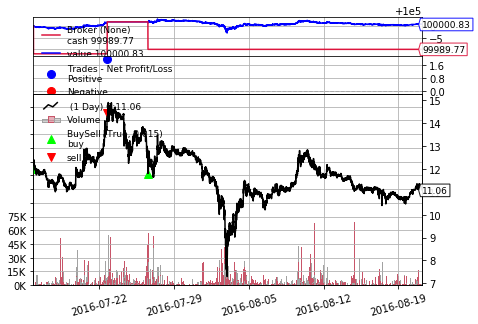

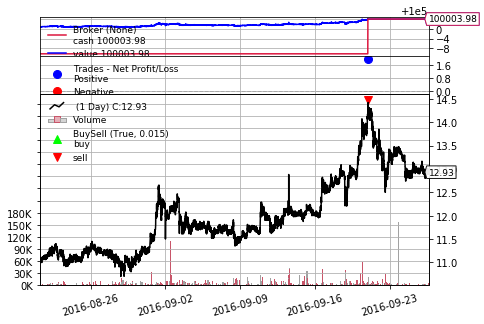

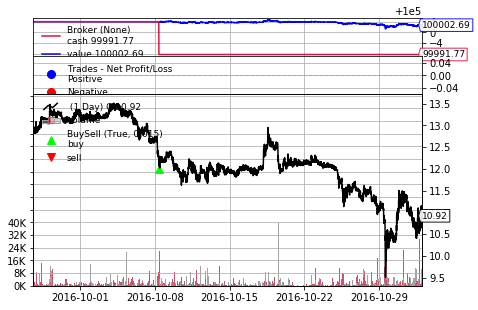

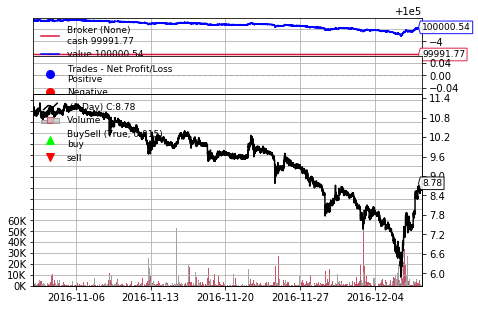

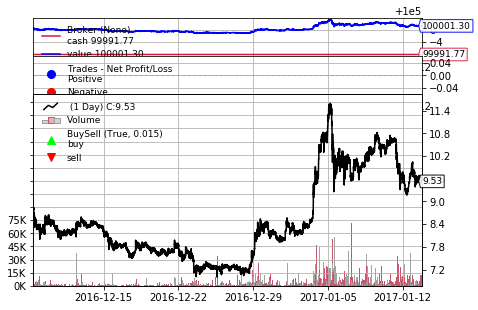

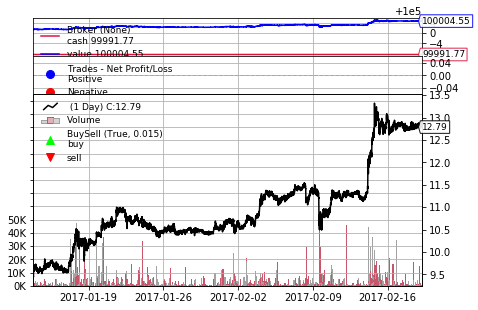

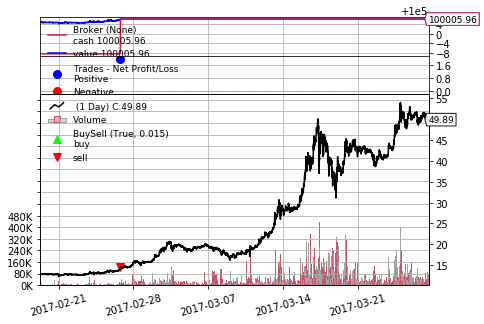

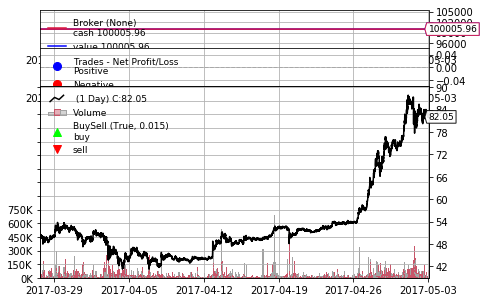

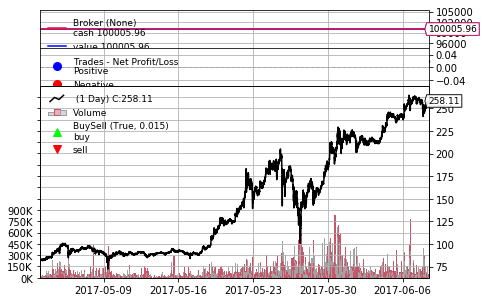

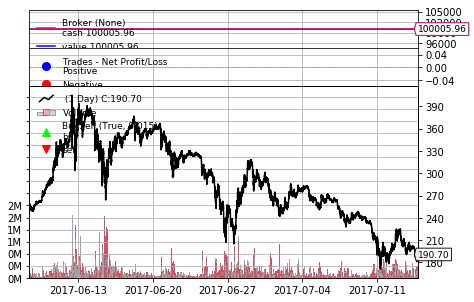

In [29]:
cerebro.plot(numfigs=10);

In [ ]:
btind.AroonUp?

In [ ]:
LinePlotterIndicator(close_over_sma, name='Close_over_SMA)